In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import math

In [15]:
def display_high_number(numbers):
    n = 3
    output = []
    for number in numbers:
        output.append(','.join([str(number)[::-1][i:i+n] for i in range(0, len(str(number)), n)])[::-1])
    return output

In [16]:
def prepare_mode_data(samples):
    return [ float(f'{s:.2f}') for s in samples]

# Firefly pixel study

In [62]:
# 312, 271 => veach scene
input_samples = "output_samples_p3d.txt"
ref_input_samples = "output_samples_p3d_1M.txt"

In [63]:
data_rgb = None
with open(input_samples, 'r') as f:
    lines = f.readlines()
    data_rgb = [ list(map(float, l.split(','))) for l in lines ]
    
ref_data_rgb = None
with open(ref_input_samples, 'r') as f:
    lines = f.readlines()
    ref_data_rgb = [ list(map(float, l.split(','))) for l in lines ]

In [64]:
data_rgb = np.array(data_rgb)
ref_data_rgb = np.array(ref_data_rgb)

# Compute means

In [96]:
# remove of outlier
data_filtered_rgb = []
for i in range(3):
    max_value = np.max(data_rgb[:, i])
    mean_value = np.mean(data_rgb[:, i])
    data_filtered_rgb.append(np.array(list(map(lambda x: mean_value if x > 2000 else x , data_rgb[:, i]))))
    
data_filtered_rgb = np.array(data_filtered_rgb)

ref_data_filtered_rgb = []
for i in range(3):
    max_value = np.max(ref_data_rgb[:, i])
    mean_value = np.mean(ref_data_rgb[:, i])
    ref_data_filtered_rgb.append(np.array(list(map(lambda x: mean_value if x > 2000 else x , ref_data_rgb[:, i]))))
    
ref_data_filtered_rgb = np.array(ref_data_filtered_rgb)

In [97]:
r_true_mean = np.mean(ref_data_filtered_rgb[0])
print(r_true_mean)

0.1959950565272526


In [98]:
np.mean(data_filtered_rgb[0])

0.19850304141985142

In [24]:
def compute_means(samples):
    
    means = []
    samples_sum = 0
    
    for i in range(len(samples)):
        samples_sum += samples[i]
        means.append(samples_sum / (i + 1))
        
    return means

# Gini value from firefly sample

In [67]:
def gini(array):
    """Calculate the Gini coefficient of a numpy array."""
    # based on bottom eq: http://www.statsdirect.com/help/content/image/stat0206_wmf.gif
    # from: http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm
    array = array.flatten() #all values are treated equally, arrays must be 1d
    if np.amin(array) < 0:
        array -= np.amin(array) #values cannot be negative
    array += 0.0000001 #values cannot be 0
    array = np.sort(array) #values must be sorted
    index = np.arange(1,array.shape[0]+1) #index per array element
    n = array.shape[0]#number of array elements
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array))) #Gini coefficient

In [68]:
def create_k_means(samples, k=11):
    
    means = []
    counters = []
    
    for i in range(k):
        means.append(0)
        counters.append(0)
        
    index = 0
    final_means = []
    for s in samples:
        
        means[index] += s
        counters[index] += 1
        
        index += 1
        
        if index >= k:
            index = 0
            
        current_means = []
        for i in range(k):
            
            if counters[i] != 0:
                current_means.append(means[i] / counters[i])
            
        final_means.append(current_means)
    
    return final_means

# Alpha-dist-MON study

In [69]:
def alpha_mon(means, nexpected=11, alpha=0.5):
    
    n = len(means)
    mIndex = int(len(means) / 2)
    
    meansSorted = sorted(means)
    
    meanSum = meansSorted[mIndex]
    weightSum = 1
    
    if n < nexpected:
        return np.median(meansSorted)
    
    for i in range(1, mIndex + 1):
        confidence = pow(alpha, i)
        
        meanSum += meansSorted[mIndex - i] * confidence
        meanSum += meansSorted[mIndex + i] * confidence
        weightSum += 2 * confidence
        
    return meanSum / weightSum

In [70]:
def alpha_dist_mon(means, nexpected=11, alpha=0.5):
    
    n = len(means)
    mIndex = int(len(means) / 2)
    
    meansSorted = sorted(means)
    
    meanSum = meansSorted[mIndex]
    weightSum = 1
    
    if n < nexpected:
        return np.median(meansSorted)
    
    for i in range(1, int(mIndex * alpha) + 1):
        
        meanSum += meansSorted[mIndex - i]
        meanSum += meansSorted[mIndex + i]
        weightSum += 2
        
    return meanSum / weightSum

### Noisy study

In [ ]:
samples_axis_mean = data_rgb[:, 0]
means_evolution_k11 = create_k_means(samples_axis_mean, k=11)
means_evolution_k15 = create_k_means(samples_axis_mean, k=15)
means_evolution_k21 = create_k_means(samples_axis_mean, k=21)

gini_data_k11 = [ gini(np.array(m)) for m in means_evolution_k11 ]
check_gini_values_k11 = np.array(list(map(lambda x: 1 if x == 0 else x, gini_data_k11)))

gini_data_k15 = [ gini(np.array(m)) for m in means_evolution_k15 ]
check_gini_values_k15 = np.array(list(map(lambda x: 1 if x == 0 else x, gini_data_k15)))

gini_data_k21 = [ gini(np.array(m)) for m in means_evolution_k21 ]
check_gini_values_k21 = np.array(list(map(lambda x: 1 if x == 0 else x, gini_data_k21)))

In [ ]:
means_evolution_k11 = create_k_means(data_rgb[:, 0], k=11)
means_evolution_k21 = create_k_means(data_rgb[:, 0], k=21)

In [ ]:
means = [ np.mean(m) for m in means_evolution_k11 ]

In [ ]:
MON_k11 = [ np.median(m) for m in means_evolution_k11 ]
MON_k21 = [ np.median(m) for m in means_evolution_k21 ]

In [ ]:
AMON_k11 = [ alpha_mon(m, 11, 0.5) for m in means_evolution_k11 ]
AMON_k21 = [ alpha_mon(m, 21, 0.5) for m in means_evolution_k21 ]

In [ ]:
GMON_k11 = [ alpha_dist_mon(m, 11, 1 - gini_data_k11[i]) for i, m in enumerate(means_evolution_k11) ]
GMON_k21 = [ alpha_dist_mon(m, 21, 1 - gini_data_k21[i]) for i, m in enumerate(means_evolution_k21) ]

In [ ]:
GMON_k11_mid = [ alpha_dist_mon(m, 11, 0.5) for i, m in enumerate(means_evolution_k11) ]
GMON_k21_mid = [ alpha_dist_mon(m, 21, 0.5) for i, m in enumerate(means_evolution_k21) ]

In [ ]:
params = {'backend': 'ps',
          'axes.labelsize': 54,
          'font.size': 40,
          'legend.fontsize': 38,
          'xtick.labelsize': 42,
          'ytick.labelsize': 42,
          'text.usetex': True,
          'font.style': 'normal',
          'font.weight': 'bold',
          'axes.linewidth': 1.5,
          'lines.linewidth': 4,
          'figure.figsize': (18, 10)}


plt.rcParams.update(params)

plt.margins(tight=True)
plt.tick_params(axis='both', width=2, length=15)

labels = ['R', 'G', 'B']

plt.plot([0, 100000], [r_true_mean, r_true_mean], lw=5, label='Expected mean', linestyle="--")
plt.plot(means, label='Mean', linewidth=4)
plt.plot(MON_k11, label='MON ($M=11$)', linewidth=4)
plt.plot(AMON_k11, label=r'$\alpha$-MON ($\alpha = 0.5$)', linewidth=4)
plt.plot(GMON_k11, label=r'$G$-MON ($\alpha = 1 - G$)', linewidth=4)
plt.plot(GMON_k11_mid, label=r'$G$-MON ($\alpha = 0.5$)', linewidth=4)
#plt.xlim(-1, 100)
        
plt.xlabel("Number of samples")
plt.ylabel(r"Estimator value")
#plt.ylim(0, 0.15)
#plt.xlim(-0.03, 6)
#plt.ylim(0.15, 0.20)
plt.legend()
#plt.xticks(np.arange(-10, 15, step=5), np.arange(-10, 15, step=5))  # Set label locations.
plt.xticks(np.arange(0, 120000, step=20000), display_high_number(np.arange(0, 120000, step=20000)))  # Set label locations.
plt.yticks(np.arange(0, 15, step=2.5), prepare_mode_data(np.arange(0, 15, step=2.5)))
#plt.xticks(fontsize=14)
#plt.yticks(fontsize=14)
plt.savefig("images/amon_estimators_outliers.png", transparent=True, bbox_inches = 'tight', pad_inches = 0.1)
plt.show()

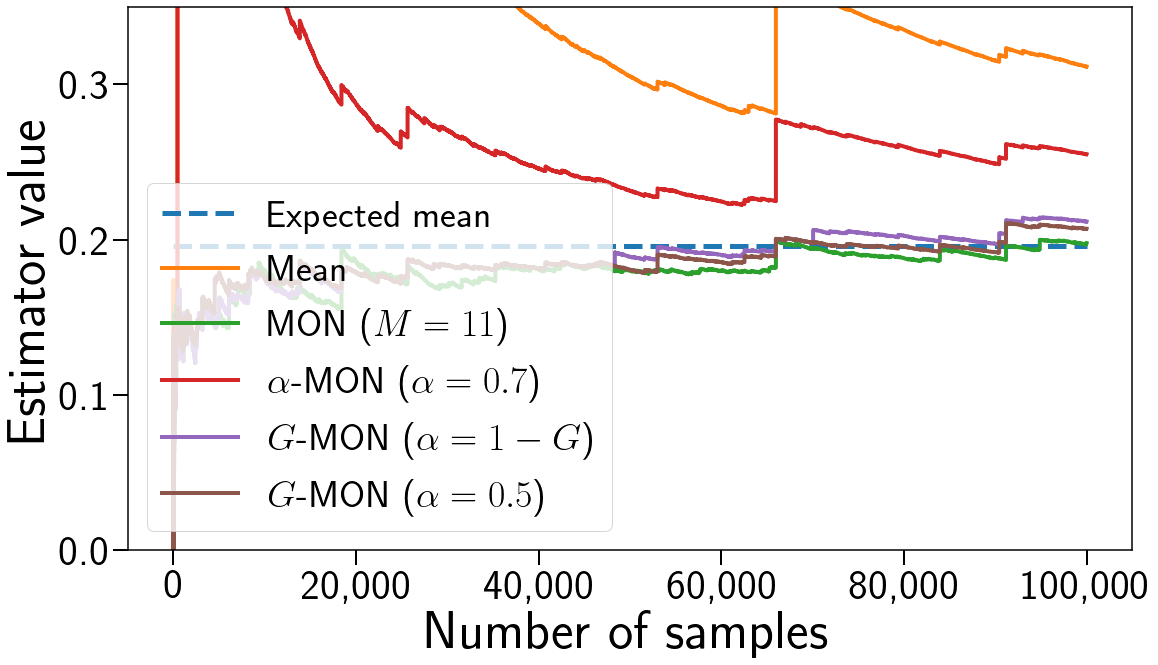

In [84]:
params = {'backend': 'ps',
          'axes.labelsize': 54,
          'font.size': 40,
          'legend.fontsize': 38,
          'xtick.labelsize': 42,
          'ytick.labelsize': 42,
          'text.usetex': True,
          'font.style': 'normal',
          'font.weight': 'bold',
          'axes.linewidth': 1.5,
          'lines.linewidth': 4,
          'figure.figsize': (18, 10)}


plt.rcParams.update(params)

plt.margins(tight=True)
plt.tick_params(axis='both', width=2, length=15)

labels = ['R', 'G', 'B']

plt.plot([0, 100000], [r_true_mean, r_true_mean], lw=5, label='Expected mean', linestyle="--")
plt.plot(means, label='Mean', linewidth=4)
plt.plot(MON_k11, label='MON ($M=11$)', linewidth=4)
plt.plot(AMON_k11, label=r'$\alpha$-MON ($\alpha = 0.7$)', linewidth=4)
plt.plot(GMON_k11, label=r'$G$-MON ($\alpha = 1 - G$)', linewidth=4)
plt.plot(GMON_k11_mid, label=r'$G$-MON ($\alpha = 0.5$)', linewidth=4)
#plt.xlim(-1, 100)
        
plt.xlabel("Number of samples")
plt.ylabel(r"Estimator value")
#plt.ylim(0, 0.15)
#plt.xlim(-0.03, 6)
plt.ylim(0, 0.35)
plt.legend()
#plt.xticks(np.arange(-10, 15, step=5), np.arange(-10, 15, step=5))  # Set label locations.
plt.xticks(np.arange(0, 120000, step=20000), display_high_number(np.arange(0, 120000, step=20000)))  # Set label locations.
plt.yticks(np.arange(0, 0.40, step=0.1), prepare_mode_data(np.arange(0, 0.45, step=0.1)))
#plt.xticks(fontsize=14)
#plt.yticks(fontsize=14)
plt.savefig("images/amon_estimators_outliers_scale.png", transparent=True, bbox_inches = 'tight', pad_inches = 0.1)
plt.show()

In [99]:
means_evolution_filtered_k11 = create_k_means(data_filtered_rgb[0], k=11)
means_evolution_filtered_k21 = create_k_means(data_filtered_rgb[0], k=21)

In [100]:
means = [ np.mean(m) for m in means_evolution_filtered_k11 ]

In [101]:
MON_k11 = [ np.median(m) for m in means_evolution_filtered_k11 ]
MON_k21 = [ np.median(m) for m in means_evolution_filtered_k21 ]

In [103]:
AMON_k11 = [ alpha_mon(m, 11, 0.7) for m in means_evolution_filtered_k11 ]
AMON_k21 = [ alpha_mon(m, 21, 0.7) for m in means_evolution_filtered_k21 ]

In [104]:
GMON_k11 = [ alpha_dist_mon(m, 11, 1 - gini_data_k11[i]) for i, m in enumerate(means_evolution_filtered_k11) ]
GMON_k21 = [ alpha_dist_mon(m, 21, 1 - gini_data_k21[i]) for i, m in enumerate(means_evolution_filtered_k21) ]

In [105]:
GMON_k11_mid = [ alpha_dist_mon(m, 11, 0.5) for i, m in enumerate(means_evolution_filtered_k11) ]
GMON_k21_mid = [ alpha_dist_mon(m, 21, 0.5) for i, m in enumerate(means_evolution_filtered_k21) ]

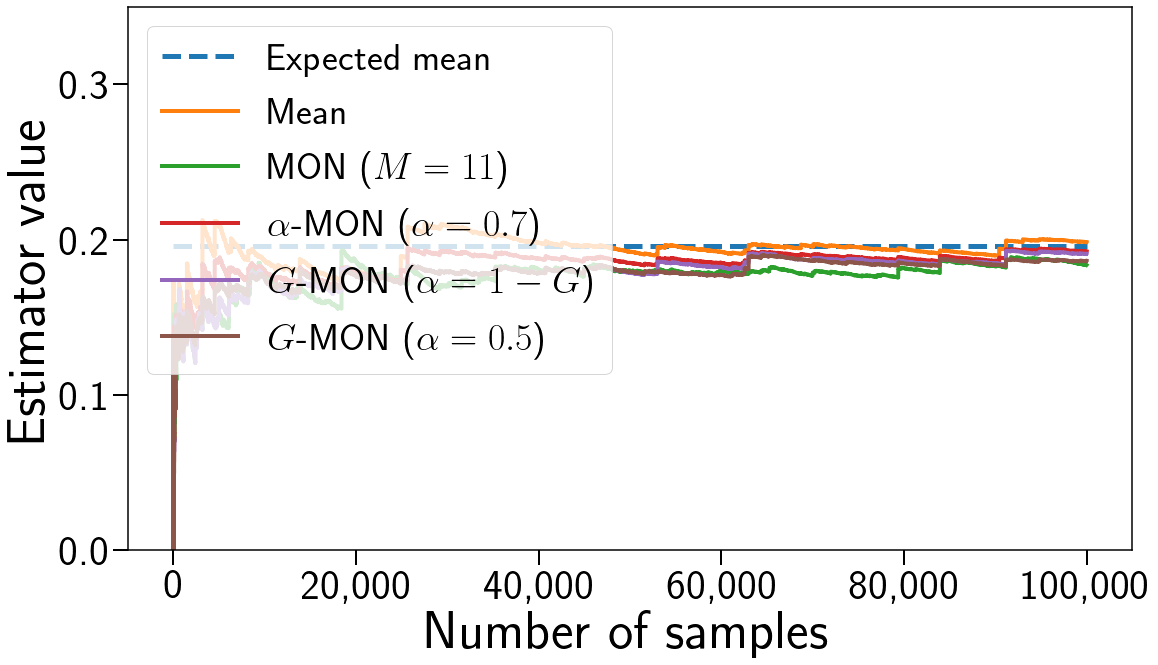

In [106]:
params = {'backend': 'ps',
          'axes.labelsize': 54,
          'font.size': 40,
          'legend.fontsize': 38,
          'xtick.labelsize': 42,
          'ytick.labelsize': 42,
          'text.usetex': True,
          'font.style': 'normal',
          'font.weight': 'bold',
          'axes.linewidth': 1.5,
          'lines.linewidth': 4,
          'figure.figsize': (18, 10)}


plt.rcParams.update(params)

plt.margins(tight=True)
plt.tick_params(axis='both', width=2, length=15)

labels = ['R', 'G', 'B']

plt.plot([0, 100000], [r_true_mean, r_true_mean], lw=5, label='Expected mean', linestyle="--")
plt.plot(means, label='Mean', linewidth=4)
plt.plot(MON_k11, label='MON ($M=11$)', linewidth=4)
plt.plot(AMON_k11, label=r'$\alpha$-MON ($\alpha = 0.7$)', linewidth=4)
plt.plot(GMON_k11, label=r'$G$-MON ($\alpha = 1 - G$)', linewidth=4)
plt.plot(GMON_k11_mid, label=r'$G$-MON ($\alpha = 0.5$)', linewidth=4)
#plt.xlim(-1, 100)
        
plt.xlabel("Number of samples")
plt.ylabel(r"Estimator value")
#plt.ylim(0, 0.15)
#plt.xlim(-0.03, 6)
#plt.ylim(0.15, 0.20)
plt.legend()
plt.ylim(0, 0.35)
#plt.xticks(np.arange(-10, 15, step=5), np.arange(-10, 15, step=5))  # Set label locations.
plt.xticks(np.arange(0, 120000, step=20000), display_high_number(np.arange(0, 120000, step=20000)))  # Set label locations.
plt.yticks(np.arange(0, 0.40, step=0.1), prepare_mode_data(np.arange(0, 0.45, step=0.1)))
#plt.xticks(fontsize=14)
#plt.yticks(fontsize=14)
plt.savefig("images/amon_estimators_no_outlier.png", transparent=True, bbox_inches = 'tight', pad_inches = 0.1)
plt.show()